[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\amitk\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\amitk\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Columns in dataset: Index(['text', 'language', 'text_length', 'tokens'], dtype='object')


c:\Users\amitk\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Validation Results:
              precision    recall  f1-score   support

          as       0.91      1.00      0.95        10
          bn       1.00      0.86      0.92         7
          en       1.00      0.83      0.91        12
          gu       1.00      1.00      1.00         6
          hi       1.00      0.83      0.91        12
          kn       1.00      1.00      1.00         6
         kok       1.00      0.83      0.91        12
          ks       0.89      0.80      0.84        10
          ml       1.00      1.00      1.00         9
          mr       0.44      1.00      0.62         4
          ne       0.80      1.00      0.89         4
          or       1.00      1.00      1.00         7
          pa       1.00      1.00      1.00         7
          sa       0.88      0.78      0.82         9
          ta       1.00      1.00      1.00         9
          te       1.00      1.00      1.00        12
          ur       0.78      1.00      0.88         7

    ac

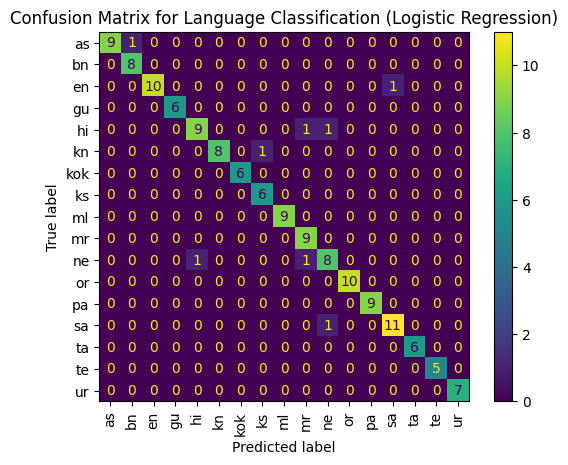

In [10]:
# feature domain of logistics regression
# using logistics regression
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import re
import unicodedata
from nltk import pos_tag
import nltk

# Download NLTK resources
nltk.download('punkt')
nltk.download('stopwords')

# Load dataset
dataset_path = 'training_dataset.csv'
data = pd.read_csv(dataset_path)
print("Columns in dataset:", data.columns)

# Ensure 'text' and 'language' columns exist in dataset
if 'text' not in data.columns or 'language' not in data.columns:
    raise KeyError("Please check that 'text' and 'language' columns are present in the dataset.")

data['text'] = data['text'].astype(str).fillna('')  # Ensure no missing or non-string values
labels = data['language']

# Define stopwords and vowels for multiple languages
stopword_sets = {
    'bn': set(stopwords.words('bengali') if 'bengali' in stopwords.fileids() else []),
    'en': set(stopwords.words('english') if 'english' in stopwords.fileids() else []),
    'gu': set(stopwords.words('gujarati') if 'gujarati' in stopwords.fileids() else []),
    'hi': set(stopwords.words('hindi') if 'hindi' in stopwords.fileids() else []),
    'kn': set(stopwords.words('kannada') if 'kannada' in stopwords.fileids() else []),
    'kok': set(['आहे', 'असे', 'आणि', 'पण', 'म्हणजे']),  # Example Konkani stopwords
    'ks': set(['کھ', 'ہے', 'اور', 'لیکن']),  # Example Kashmiri stopwords
    'ml': set(stopwords.words('malayalam') if 'malayalam' in stopwords.fileids() else []),
    'mr': set(stopwords.words('marathi') if 'marathi' in stopwords.fileids() else []),
    'ne': set(['छ', 'वा', 'र', 'तर', 'त', 'मा', 'देखि']),  # Example Nepali stopwords
    'or': set(stopwords.words('oriya') if 'oriya' in stopwords.fileids() else []),
    'pa': set(['ਤੇ', 'ਹੈ', 'ਅਤੇ', 'ਜੋ', 'ਨਹੀਂ']),  # Example Punjabi stopwords
    'sa': set(['च', 'त', 'हि', 'एव', 'वा']),  # Example Sanskrit stopwords
    'ta': set(stopwords.words('tamil') if 'tamil' in stopwords.fileids() else []),
    'te': set(stopwords.words('telugu') if 'telugu' in stopwords.fileids() else []),
    'ur': set(stopwords.words('urdu') if 'urdu' in stopwords.fileids() else []),
}

vowel_sets = {
    'bn': 'অআইঈউঊঋএঐওঔ',  # Bengali
    'en': 'aeiou',  # English
    'gu': 'અઆઇઈઉઊઋએઐઓઔ',  # Gujarati
    'hi': 'अआइईउऊऋएऐओऔ',  # Hindi
    'kn': 'ಅಆಇಈಉಊಋಎಏಐಒಔ',  # Kannada
    'kok': 'अआइईउऊऋएऐओऔ',  # Konkani (Devanagari)
    'ks': 'اےاؤ',  # Kashmiri (Arabic script example)
    'ml': 'അആഇഈഉഊഋഎഏഐഒഔ',  # Malayalam
    'mr': 'अआइईउऊऋएऐओऔ',  # Marathi
    'ne': 'अआइईउऊऋएऐओऔ',  # Nepali
    'or': 'ଅଆଇଈଉଊଋଏଐଓଔ',  # Odia
    'pa': 'ਅਆਇਈਉਊਏਐਓਔ',  # Punjabi
    'sa': 'अआइईउऊऋएऐओऔ',  # Sanskrit (Devanagari)
    'ta': 'அஆஇஈஉஊஎஏஐஒஓஔ',  # Tamil
    'te': 'అఆఇఈఉఊఎఏఐఒఓఔ',  # Telugu
    'ur': 'اےاؤ',  # Urdu
}

# Feature extraction functions
def average_word_length(text):
    words = word_tokenize(text)
    return np.mean([len(word) for word in words]) if words else 0

def average_sentence_length(text):
    sentences = re.split(r'[.!?]', text)
    sentences = [sentence.strip() for sentence in sentences if sentence.strip()]
    return np.mean([len(sentence.split()) for sentence in sentences]) if sentences else 0

def calculate_stopword_count(text, language):
    words = word_tokenize(text)
    stopword_set = stopword_sets.get(language, set())
    return sum(1 for word in words if word.lower() in stopword_set)

def calculate_vowel_count(text, language):
    vowels = vowel_sets.get(language, '')
    return sum(1 for char in text if char in vowels)

def calculate_diacritic_frequency(text):
    return sum(1 for char in text if unicodedata.category(char) == 'Mn')

def character_trigram_count(text):
    return len([text[i:i+3] for i in range(len(text) - 2)])

def calculate_pos_ratios(text):
    words = word_tokenize(text)
    tagged = pos_tag(words)
    pos_counts = pd.Series([tag for _, tag in tagged])
    noun_ratio = sum(pos_counts.str.startswith('NN')) / len(words) if len(words) else 0
    verb_ratio = sum(pos_counts.str.startswith('VB')) / len(words) if len(words) else 0
    return noun_ratio, verb_ratio

# Additional Feature Functions
def calculate_prefix_suffix_frequency(words):
    prefixes = [word[:3] for word in words if len(word) >= 3]
    suffixes = [word[-3:] for word in words if len(word) >= 3]
    return len(prefixes), len(suffixes)

def script_based_feature(text):
    if re.search('[\u0980-\u09FF]', text):  # Bengali
        return "bn"
    elif re.search('[\u0A80-\u0AFF]', text):  # Gujarati
        return "gu"
    elif re.search('[\u0900-\u097F]', text):  # Hindi
        return "hi"
    elif re.search('[\u0C80-\u0CFF]', text):  # Kannada
        return "kn"
    elif re.search('[\u0900-\u097F]', text) and re.search('[\u0900-\u091F]', text):  # Konkani
        return "kok"
    elif re.search('[\u0600-\u06FF]', text):  # Kashmiri
        return "ks"
    elif re.search('[\u0D00-\u0D7F]', text):  # Malayalam
        return "ml"
    elif re.search('[\u0900-\u097F]', text):  # Marathi
        return "mr"
    elif re.search('[\u0900-\u097F]', text):  # Nepali
        return "ne"
    elif re.search('[\u0B00-\u0B7F]', text):  # Odia
        return "or"
    elif re.search('[\u0A00-\u0A7F]', text):  # Punjabi
        return "pa"
    elif re.search('[\u0900-\u097F]', text):  # Sanskrit
        return "sa"
    elif re.search('[\u0B80-\u0BFF]', text):  # Tamil
        return "ta"
    elif re.search('[\u0C00-\u0C7F]', text):  # Telugu
        return "te"
    elif re.search('[\u0600-\u06FF]', text):  # Urdu
        return "ur"
    elif re.search('[\u0980-\u09FF]', text):  # Assamese
        return "as"
    elif re.search('[a-zA-Z]', text):  # English
        return "en"
    else:
        return "other"

# Update extract_features to include new features
def extract_features(row):
    text = row['text']
    language = row['language']
    words = word_tokenize(text)

    prefix_count, suffix_count = calculate_prefix_suffix_frequency(words)
    script_feature = script_based_feature(text)

    return {
        'avg_word_length': average_word_length(text),
        'avg_sentence_length': average_sentence_length(text),
        'stopword_count': calculate_stopword_count(text, language),
        'vowel_count': calculate_vowel_count(text, language),
        'diacritic_freq': calculate_diacritic_frequency(text),
        'trigram_count': character_trigram_count(text),
        'noun_ratio': calculate_pos_ratios(text)[0],
        'verb_ratio': calculate_pos_ratios(text)[1],
        'prefix_count': prefix_count,
        'suffix_count': suffix_count,
        'script_feature': script_feature,
    }

# Apply feature extraction
data['extracted_features'] = data.apply(extract_features, axis=1)
feature_df = pd.json_normalize(data['extracted_features'])

# Convert script_feature to numerical encoding (one-hot encoding or label encoding)
script_feature_encoded = pd.get_dummies(feature_df['script_feature'], prefix='script')
feature_df = pd.concat([feature_df.drop(columns=['script_feature']), script_feature_encoded], axis=1)

# TF-IDF Extraction
tfidf_vectorizer = TfidfVectorizer(max_features=100)
tfidf_matrix = tfidf_vectorizer.fit_transform(data['text']).toarray()

# Combine all features
X = np.hstack((feature_df.to_numpy(), tfidf_matrix))
y = labels.values
# Scale the combined feature set
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-Test Split
X_train, X_temp, y_train, y_temp = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Train Logistic Regression model
lr_model = LogisticRegression(max_iter=1000, multi_class='multinomial', solver='lbfgs', random_state=42)
lr_model.fit(X_train, y_train)

# Validation Results
y_val_pred = lr_model.predict(X_val)
print("Validation Results:")
print(classification_report(y_val, y_val_pred))

# Test Results
y_test_pred = lr_model.predict(X_test)
print("Test Results:")
print(classification_report(y_test, y_test_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_test_pred, labels=lr_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=lr_model.classes_)
disp.plot(cmap='viridis', xticks_rotation='vertical')
plt.title("Confusion Matrix for Language Classification (Logistic Regression)")
plt.show()


Validation Results:
              precision    recall  f1-score   support

          as       0.90      0.90      0.90        10
          bn       0.86      0.86      0.86         7
          en       1.00      0.92      0.96        12
          gu       1.00      1.00      1.00         6
          hi       0.91      0.83      0.87        12
          kn       0.86      1.00      0.92         6
         kok       0.91      0.83      0.87        12
          ks       1.00      1.00      1.00        10
          ml       1.00      1.00      1.00         9
          mr       0.50      1.00      0.67         4
          ne       1.00      0.50      0.67         4
          or       1.00      1.00      1.00         7
          pa       1.00      1.00      1.00         7
          sa       0.78      0.78      0.78         9
          ta       1.00      1.00      1.00         9
          te       1.00      1.00      1.00        12
          ur       1.00      1.00      1.00         7

    ac

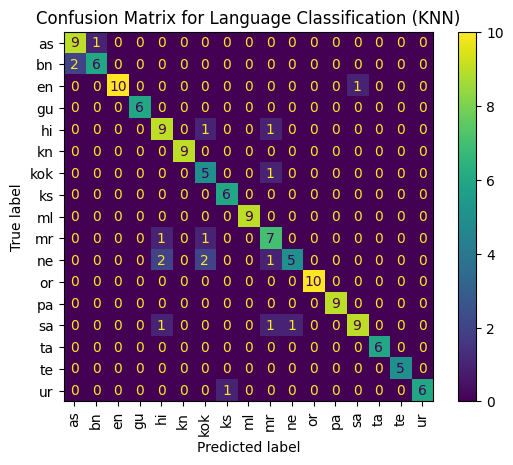

In [11]:
# feature domain using knn
# using knn
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from scipy.fft import fft2, fftshift
import seaborn as sns

# Assume feature extraction functions and dataset preprocessing are the same as your original code.

# Combine all features (feature_df + TF-IDF matrix)
X = np.hstack((feature_df.to_numpy(), tfidf_matrix))
y = labels.values

# Scale features (important for KNN)
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Train-Test Split
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Train KNN model
k = 5  # Number of neighbors
knn_model = KNeighborsClassifier(n_neighbors=k, metric='euclidean')  # Euclidean distance metric
knn_model.fit(X_train, y_train)

# Validation Results
y_val_pred = knn_model.predict(X_val)
print("Validation Results:")
print(classification_report(y_val, y_val_pred))

# Test Results
y_test_pred = knn_model.predict(X_test)
print("Test Results:")
print(classification_report(y_test, y_test_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_test_pred, labels=np.unique(y_test))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_test))
disp.plot(cmap='viridis', xticks_rotation='vertical')
plt.title("Confusion Matrix for Language Classification (KNN)")
plt.show()


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\amitk\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\amitk\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Columns in dataset: Index(['text', 'language', 'text_length', 'tokens'], dtype='object')
Validation Results:
              precision    recall  f1-score   support

          as       1.00      1.00      1.00        10
          bn       1.00      1.00      1.00         7
          en       1.00      0.92      0.96        12
          gu       1.00      1.00      1.00         6
          hi       1.00      1.00      1.00        12
          kn       1.00      1.00      1.00         6
         kok       0.83      0.83      0.83        12
          ks       0.91      1.00      0.95        10
          ml       1.00      1.00      1.00         9
          mr       0.80      1.00      0.89         4
          ne       0.67      1.00      0.80         4
          or       1.00      1.00      1.00         7
          pa       1.00      1.00      1.00         7
          sa       1.00      0.67      0.80         9
          ta       1.00      1.00      1.00         9
          te       1.00   

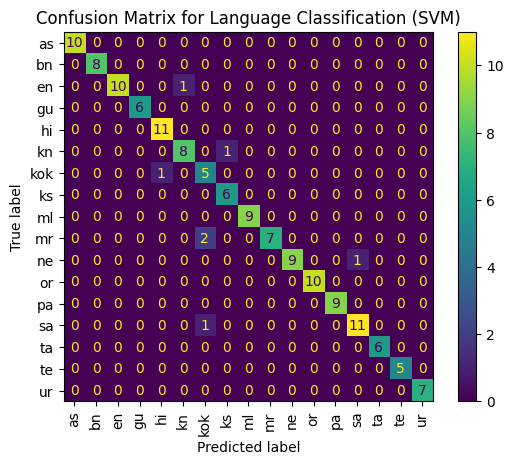

In [12]:
# feature domain using svm
# using svm
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from scipy.fft import fft2, fftshift
import seaborn as sns
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import re
import unicodedata
from nltk import pos_tag
import nltk

# Download NLTK resources
nltk.download('punkt')
nltk.download('stopwords')

# Load dataset
dataset_path = 'training_dataset.csv'
data = pd.read_csv(dataset_path)
print("Columns in dataset:", data.columns)

# Ensure 'text' and 'language' columns exist in dataset
if 'text' not in data.columns or 'language' not in data.columns:
    raise KeyError("Please check that 'text' and 'language' columns are present in the dataset.")

data['text'] = data['text'].astype(str).fillna('')  # Ensure no missing or non-string values
labels = data['language']

# Define stopwords and vowels for multiple languages
stopword_sets = {
    'bn': set(stopwords.words('bengali') if 'bengali' in stopwords.fileids() else []),
    'en': set(stopwords.words('english') if 'english' in stopwords.fileids() else []),
    'gu': set(stopwords.words('gujarati') if 'gujarati' in stopwords.fileids() else []),
    'hi': set(stopwords.words('hindi') if 'hindi' in stopwords.fileids() else []),
    'kn': set(stopwords.words('kannada') if 'kannada' in stopwords.fileids() else []),
    'kok': set(['आहे', 'असे', 'आणि', 'पण', 'म्हणजे']),  # Example Konkani stopwords
    'ks': set(['کھ', 'ہے', 'اور', 'لیکن']),  # Example Kashmiri stopwords
    'ml': set(stopwords.words('malayalam') if 'malayalam' in stopwords.fileids() else []),
    'mr': set(stopwords.words('marathi') if 'marathi' in stopwords.fileids() else []),
    'ne': set(['छ', 'वा', 'र', 'तर', 'त', 'मा', 'देखि']),  # Example Nepali stopwords
    'or': set(stopwords.words('oriya') if 'oriya' in stopwords.fileids() else []),
    'pa': set(['ਤੇ', 'ਹੈ', 'ਅਤੇ', 'ਜੋ', 'ਨਹੀਂ']),  # Example Punjabi stopwords
    'sa': set(['च', 'त', 'हि', 'एव', 'वा']),  # Example Sanskrit stopwords
    'ta': set(stopwords.words('tamil') if 'tamil' in stopwords.fileids() else []),
    'te': set(stopwords.words('telugu') if 'telugu' in stopwords.fileids() else []),
    'ur': set(stopwords.words('urdu') if 'urdu' in stopwords.fileids() else []),
}

vowel_sets = {
    'bn': 'অআইঈউঊঋএঐওঔ',  # Bengali
    'en': 'aeiou',  # English
    'gu': 'અઆઇઈઉઊઋએઐઓઔ',  # Gujarati
    'hi': 'अआइईउऊऋएऐओऔ',  # Hindi
    'kn': 'ಅಆಇಈಉಊಋಎಏಐಒಔ',  # Kannada
    'kok': 'अआइईउऊऋएऐओऔ',  # Konkani (Devanagari)
    'ks': 'اےاؤ',  # Kashmiri (Arabic script example)
    'ml': 'അആഇഈഉഊഋഎഏഐഒഔ',  # Malayalam
    'mr': 'अआइईउऊऋएऐओऔ',  # Marathi
    'ne': 'अआइईउऊऋएऐओऔ',  # Nepali
    'or': 'ଅଆଇଈଉଊଋଏଐଓଔ',  # Odia
    'pa': 'ਅਆਇਈਉਊਏਐਓਔ',  # Punjabi
    'sa': 'अआइईउऊऋएऐओऔ',  # Sanskrit (Devanagari)
    'ta': 'அஆஇஈஉஊஎஏஐஒஓஔ',  # Tamil
    'te': 'అఆఇఈఉఊఎఏఐఒఓఔ',  # Telugu
    'ur': 'اےاؤ',  # Urdu
}

# Feature extraction functions
def average_word_length(text):
    words = word_tokenize(text)
    return np.mean([len(word) for word in words]) if words else 0

def average_sentence_length(text):
    sentences = re.split(r'[.!?]', text)
    sentences = [sentence.strip() for sentence in sentences if sentence.strip()]
    return np.mean([len(sentence.split()) for sentence in sentences]) if sentences else 0

def calculate_stopword_count(text, language):
    words = word_tokenize(text)
    stopword_set = stopword_sets.get(language, set())
    return sum(1 for word in words if word.lower() in stopword_set)

def calculate_vowel_count(text, language):
    vowels = vowel_sets.get(language, '')
    return sum(1 for char in text if char in vowels)

def calculate_diacritic_frequency(text):
    return sum(1 for char in text if unicodedata.category(char) == 'Mn')

def character_trigram_count(text):
    return len([text[i:i+3] for i in range(len(text) - 2)])

def calculate_pos_ratios(text):
    words = word_tokenize(text)
    tagged = pos_tag(words)
    pos_counts = pd.Series([tag for _, tag in tagged])
    noun_ratio = sum(pos_counts.str.startswith('NN')) / len(words) if len(words) else 0
    verb_ratio = sum(pos_counts.str.startswith('VB')) / len(words) if len(words) else 0
    return noun_ratio, verb_ratio

# Additional Feature Functions
def calculate_prefix_suffix_frequency(words):
    prefixes = [word[:3] for word in words if len(word) >= 3]
    suffixes = [word[-3:] for word in words if len(word) >= 3]
    return len(prefixes), len(suffixes)

def script_based_feature(text):
    if re.search('[\u0980-\u09FF]', text):  # Bengali
        return "bn"
    elif re.search('[\u0A80-\u0AFF]', text):  # Gujarati
        return "gu"
    elif re.search('[\u0900-\u097F]', text):  # Hindi
        return "hi"
    elif re.search('[\u0C80-\u0CFF]', text):  # Kannada
        return "kn"
    elif re.search('[\u0900-\u097F]', text) and re.search('[\u0900-\u091F]', text):  # Konkani
        return "kok"
    elif re.search('[\u0600-\u06FF]', text):  # Kashmiri
        return "ks"
    elif re.search('[\u0D00-\u0D7F]', text):  # Malayalam
        return "ml"
    elif re.search('[\u0900-\u097F]', text):  # Marathi
        return "mr"
    elif re.search('[\u0900-\u097F]', text):  # Nepali
        return "ne"
    elif re.search('[\u0B00-\u0B7F]', text):  # Odia
        return "or"
    elif re.search('[\u0A00-\u0A7F]', text):  # Punjabi
        return "pa"
    elif re.search('[\u0900-\u097F]', text):  # Sanskrit
        return "sa"
    elif re.search('[\u0B80-\u0BFF]', text):  # Tamil
        return "ta"
    elif re.search('[\u0C00-\u0C7F]', text):  # Telugu
        return "te"
    elif re.search('[\u0600-\u06FF]', text):  # Urdu
        return "ur"
    elif re.search('[\u0980-\u09FF]', text):  # Assamese
        return "as"
    elif re.search('[a-zA-Z]', text):  # English
        return "en"
    else:
        return "other"

# Update extract_features to include new features
def extract_features(row):
    text = row['text']
    language = row['language']
    words = word_tokenize(text)

    prefix_count, suffix_count = calculate_prefix_suffix_frequency(words)
    script_feature = script_based_feature(text)

    return {
        'avg_word_length': average_word_length(text),
        'avg_sentence_length': average_sentence_length(text),
        'stopword_count': calculate_stopword_count(text, language),
        'vowel_count': calculate_vowel_count(text, language),
        'diacritic_freq': calculate_diacritic_frequency(text),
        'trigram_count': character_trigram_count(text),
        'noun_ratio': calculate_pos_ratios(text)[0],
        'verb_ratio': calculate_pos_ratios(text)[1],
        'prefix_count': prefix_count,
        'suffix_count': suffix_count,
        'script_feature': script_feature,
    }
#  Apply feature extraction
data['extracted_features'] = data.apply(extract_features, axis=1)
feature_df = pd.json_normalize(data['extracted_features'])

# Convert script_feature to numerical encoding (one-hot encoding or label encoding)
script_feature_encoded = pd.get_dummies(feature_df['script_feature'], prefix='script')
feature_df = pd.concat([feature_df.drop(columns=['script_feature']), script_feature_encoded], axis=1)

# TF-IDF Extraction
tfidf_vectorizer = TfidfVectorizer(max_features=100)
tfidf_matrix = tfidf_vectorizer.fit_transform(data['text']).toarray()

# Combine all features
X = np.hstack((feature_df.to_numpy(), tfidf_matrix))
y = labels.values

# Train-Test Split
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Train SVM model
svm_model = SVC(kernel='linear', probability=True)  # Use 'linear' kernel, can be changed to 'rbf' or others
svm_model.fit(X_train, y_train)

# Validation Results
y_val_pred = svm_model.predict(X_val)
print("Validation Results:")
print(classification_report(y_val, y_val_pred))

# Test Results
y_test_pred = svm_model.predict(X_test)
print("Test Results:")
print(classification_report(y_test, y_test_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_test_pred, labels=np.unique(y_test))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_test))
disp.plot(cmap='viridis', xticks_rotation='vertical')
plt.title("Confusion Matrix for Language Classification (SVM)")
plt.show()


Naive Bayes - Validation Results:
              precision    recall  f1-score   support

          as       1.00      1.00      1.00        10
          bn       1.00      1.00      1.00         7
          en       1.00      0.92      0.96        12
          gu       1.00      1.00      1.00         6
          hi       1.00      0.92      0.96        12
          kn       1.00      1.00      1.00         6
         kok       0.91      0.83      0.87        12
          ks       1.00      0.90      0.95        10
          ml       1.00      1.00      1.00         9
          mr       0.60      0.75      0.67         4
          ne       1.00      0.75      0.86         4
          or       1.00      1.00      1.00         7
          pa       1.00      1.00      1.00         7
          sa       0.67      0.89      0.76         9
          ta       1.00      1.00      1.00         9
          te       1.00      1.00      1.00        12
          ur       0.88      1.00      0.93    

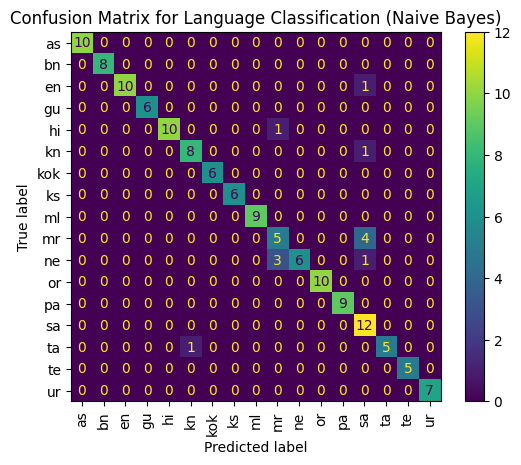

Random Forest - Validation Results:
              precision    recall  f1-score   support

          as       1.00      1.00      1.00        10
          bn       1.00      1.00      1.00         7
          en       1.00      0.92      0.96        12
          gu       1.00      1.00      1.00         6
          hi       1.00      1.00      1.00        12
          kn       1.00      1.00      1.00         6
         kok       1.00      0.75      0.86        12
          ks       0.90      0.90      0.90        10
          ml       1.00      1.00      1.00         9
          mr       0.57      1.00      0.73         4
          ne       1.00      0.75      0.86         4
          or       1.00      1.00      1.00         7
          pa       1.00      1.00      1.00         7
          sa       0.80      0.89      0.84         9
          ta       1.00      1.00      1.00         9
          te       1.00      1.00      1.00        12
          ur       0.88      1.00      0.93  

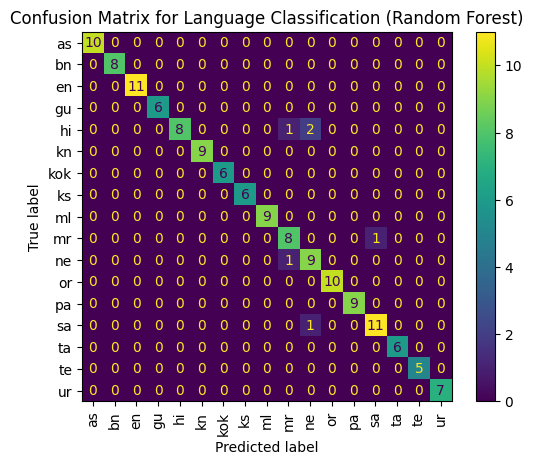

In [4]:
# feature domain using naive byes and random forest
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier

# Train Naive Bayes model
nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)

# Validation Results - Naive Bayes
y_val_pred_nb = nb_model.predict(X_val)
print("Naive Bayes - Validation Results:")
print(classification_report(y_val, y_val_pred_nb))

# Test Results - Naive Bayes
y_test_pred_nb = nb_model.predict(X_test)
print("Naive Bayes - Test Results:")
print(classification_report(y_test, y_test_pred_nb))

# Confusion Matrix - Naive Bayes
cm_nb = confusion_matrix(y_test, y_test_pred_nb, labels=np.unique(y_test))
disp_nb = ConfusionMatrixDisplay(confusion_matrix=cm_nb, display_labels=np.unique(y_test))
disp_nb.plot(cmap='viridis', xticks_rotation='vertical')
plt.title("Confusion Matrix for Language Classification (Naive Bayes)")
plt.show()

# Train Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Validation Results - Random Forest
y_val_pred_rf = rf_model.predict(X_val)
print("Random Forest - Validation Results:")
print(classification_report(y_val, y_val_pred_rf))

# Test Results - Random Forest
y_test_pred_rf = rf_model.predict(X_test)
print("Random Forest - Test Results:")
print(classification_report(y_test, y_test_pred_rf))

# Confusion Matrix - Random Forest
cm_rf = confusion_matrix(y_test, y_test_pred_rf, labels=np.unique(y_test))
disp_rf = ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels=np.unique(y_test))
disp_rf.plot(cmap='viridis', xticks_rotation='vertical')
plt.title("Confusion Matrix for Language Classification (Random Forest)")
plt.show()



Training K-Nearest Neighbors...
K-Nearest Neighbors Accuracy: 0.7175
K-Nearest Neighbors Classification Report:
               precision    recall  f1-score   support

          as       0.58      1.00      0.73        15
          bn       0.95      0.72      0.82        25
          en       1.00      0.90      0.95        31
          gu       0.52      0.73      0.61        15
          hi       0.94      0.89      0.92        19
          kn       0.45      0.42      0.43        24
         kok       0.89      0.76      0.82        21
          ks       0.85      0.85      0.85        20
          ml       0.42      0.31      0.36        16
          mr       0.67      0.70      0.68        20
          ne       0.63      0.67      0.65        18
          or       0.81      0.89      0.85        28
          pa       1.00      1.00      1.00        13
          sa       0.38      0.39      0.38        23
          ta       0.47      0.35      0.40        23
          te       0.

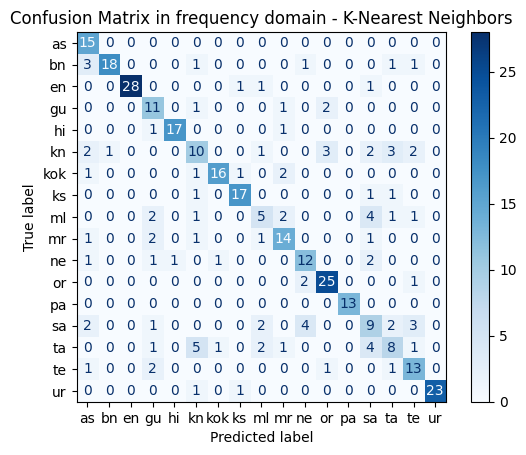


Training Support Vector Machine (SVM)...
Support Vector Machine (SVM) Accuracy: 0.7119
Support Vector Machine (SVM) Classification Report:
               precision    recall  f1-score   support

          as       0.88      1.00      0.94        15
          bn       1.00      0.72      0.84        25
          en       1.00      0.94      0.97        31
          gu       1.00      0.47      0.64        15
          hi       1.00      0.89      0.94        19
          kn       0.73      0.33      0.46        24
         kok       1.00      0.76      0.86        21
          ks       1.00      0.75      0.86        20
          ml       1.00      0.31      0.48        16
          mr       0.52      0.80      0.63        20
          ne       0.91      0.56      0.69        18
          or       0.93      0.89      0.91        28
          pa       1.00      1.00      1.00        13
          sa       0.39      0.30      0.34        23
          ta       0.17      0.61      0.27     

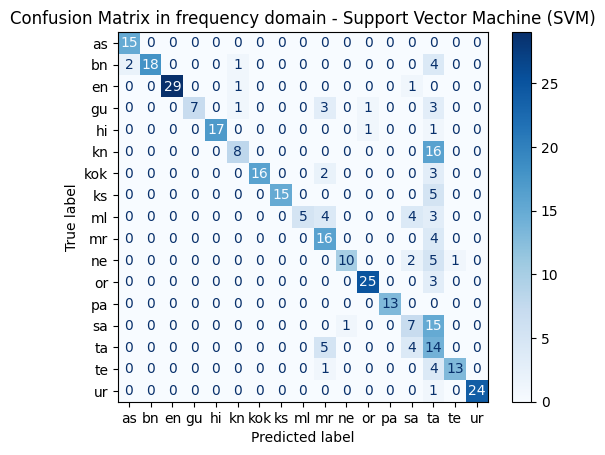


Training Logistic Regression...
Logistic Regression Accuracy: 0.7090
Logistic Regression Classification Report:
               precision    recall  f1-score   support

          as       0.94      1.00      0.97        15
          bn       1.00      0.76      0.86        25
          en       1.00      0.90      0.95        31
          gu       1.00      0.47      0.64        15
          hi       1.00      0.84      0.91        19
          kn       0.73      0.33      0.46        24
         kok       1.00      0.71      0.83        21
          ks       0.94      0.75      0.83        20
          ml       1.00      0.31      0.48        16
          mr       0.47      0.80      0.59        20
          ne       0.81      0.72      0.76        18
          or       0.96      0.89      0.93        28
          pa       1.00      1.00      1.00        13
          sa       0.30      0.35      0.32        23
          ta       0.16      0.48      0.24        23
          te       0.

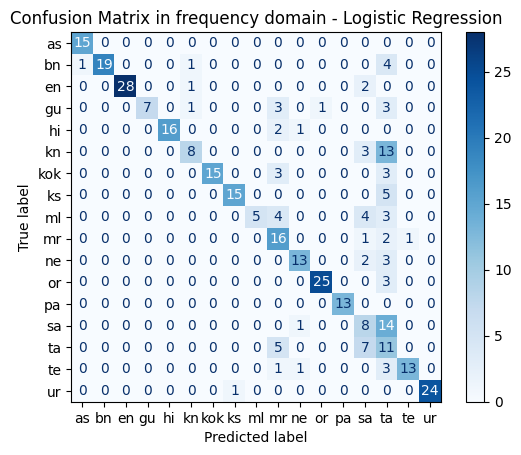


Training Naive Bayes...
Naive Bayes Accuracy: 0.7175
Naive Bayes Classification Report:
               precision    recall  f1-score   support

          as       1.00      0.93      0.97        15
          bn       0.95      0.80      0.87        25
          en       1.00      0.94      0.97        31
          gu       0.71      0.67      0.69        15
          hi       1.00      0.84      0.91        19
          kn       0.73      0.33      0.46        24
         kok       0.89      0.76      0.82        21
          ks       1.00      0.75      0.86        20
          ml       0.21      0.44      0.28        16
          mr       0.79      0.55      0.65        20
          ne       1.00      0.50      0.67        18
          or       1.00      0.89      0.94        28
          pa       1.00      1.00      1.00        13
          sa       0.67      0.26      0.38        23
          ta       0.23      0.74      0.35        23
          te       1.00      0.72      0.84  

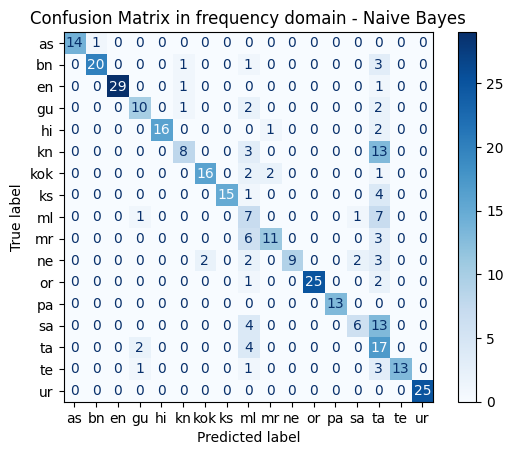

In [5]:
# frequency domain using Naive byes,knn,svm,logistics regression
from scipy.fft import fft
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
import matplotlib.pyplot as plt

# Assuming numeric features and tfidf_matrix are available
numeric_features = ['avg_word_length', 'avg_sentence_length', 
                    'stopword_count', 'vowel_count', 
                    'diacritic_freq', 'trigram_count']

# Transform numeric features to frequency domain using FFT
def transform_to_frequency(features):
    return np.abs(fft(features, axis=0))

fft_features = {}
for feature in numeric_features:
    fft_features[f"{feature}_freq"] = transform_to_frequency(feature_df[feature].values.reshape(-1, 1))

# Combine original and FFT-transformed features
original_features = feature_df[numeric_features].values
fft_features_array = np.column_stack([fft_features[f"{f}_freq"] for f in numeric_features])
X = np.hstack((original_features, fft_features_array, tfidf_matrix))

# Standardize features
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

# Oversample minority classes using SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Model training and evaluation function
def train_and_evaluate_model(model, model_name):
    print(f"\nTraining {model_name}...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    # Metrics
    accuracy = accuracy_score(y_test, y_pred)
    print(f"{model_name} Accuracy: {accuracy:.4f}")
    print(f"{model_name} Classification Report:\n", classification_report(y_test, y_pred))
    
    # Confusion Matrix
    conf_matrix = confusion_matrix(y_test, y_pred)
    ConfusionMatrixDisplay(conf_matrix, display_labels=np.unique(y)).plot(cmap='Blues')
    plt.title(f"Confusion Matrix in frequency domain - {model_name}")
    plt.show()

# Initialize and train models
models = {
    "K-Nearest Neighbors": KNeighborsClassifier(n_neighbors=5),
    "Support Vector Machine (SVM)": SVC(kernel='rbf', C=1, gamma='scale', random_state=42),
    "Logistic Regression": LogisticRegression(max_iter=500, random_state=42),
    "Naive Bayes": MultinomialNB()
}

for model_name, model in models.items():
    train_and_evaluate_model(model, model_name)


Accuracy with Frequency Features: 0.7768361581920904
Best Parameters with Frequency Features: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
Classification Report with Frequency Features:
               precision    recall  f1-score   support

          as       0.79      1.00      0.88        15
          bn       0.87      0.80      0.83        25
          en       1.00      0.94      0.97        31
          gu       0.62      0.67      0.65        15
          hi       1.00      0.84      0.91        19
          kn       0.76      0.54      0.63        24
         kok       0.90      0.86      0.88        21
          ks       0.83      0.95      0.88        20
          ml       0.80      0.50      0.62        16
          mr       0.76      0.80      0.78        20
          ne       0.62      0.56      0.59        18
          or       0.73      0.86      0.79        28
          pa       1.00      1.00      1.00        13
          sa 

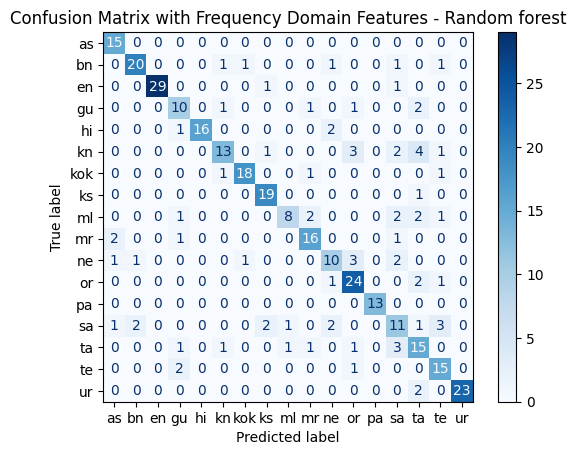

In [6]:
# frequency domain using random forest

from scipy.fft import fft
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Assuming extracted numeric features are already calculated in `feature_df`
# Ensure the following numeric features exist in `feature_df`
numeric_features = ['avg_word_length', 'avg_sentence_length', 
                    'stopword_count', 'vowel_count', 
                    'diacritic_freq', 'trigram_count']

# Transform selected numeric features to frequency domain using FFT
def transform_to_frequency(features):
    return np.abs(fft(features, axis=0))  # Apply FFT and take magnitude

# Apply FFT to numeric features
fft_features = {}
for feature in numeric_features:
    fft_features[f"{feature}_freq"] = transform_to_frequency(feature_df[feature].values.reshape(-1, 1))

# Combine original and FFT-transformed features
original_features = feature_df[numeric_features].values
fft_features_array = np.column_stack([fft_features[f"{f}_freq"] for f in numeric_features])
X = np.hstack((original_features, fft_features_array, tfidf_matrix))

# Standardize features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Oversample minority classes using SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Model training and evaluation with Random Forest
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
grid = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=3, scoring='accuracy', n_jobs=-1)
grid.fit(X_train, y_train)

# Best model evaluation
best_rf = grid.best_estimator_
y_pred = best_rf.predict(X_test)

# Evaluate results
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy with Frequency Features:", accuracy)
print("Best Parameters with Frequency Features:", grid.best_params_)
print("Classification Report with Frequency Features:\n", classification_report(y_test, y_pred))

# Plot the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(conf_matrix, display_labels=np.unique(y)).plot(cmap='Blues')
plt.title("Confusion Matrix with Frequency Domain Features - Random forest")
plt.show()
